In [164]:
import os
import random
import torch
import scipy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

from tools.data_setter import cifar_100_setter
from tools.generator import generate_sample_info
from models import cifar, imagenet

In [171]:
def get_entropy(img, model):
    probs = torch.softmax(model(img), dim=1)
    log_probs = torch.log(probs)
    entropy = -torch.sum(probs*log_probs, dim = 1 )
    pred_label = torch.argmax(probs).item()
    return pred_label, entropy

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

device = torch.device('cuda:1')
teacher_epoch = "199"
student_epoch = "199"
teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
student = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
filename = "./model_checkpoints/cifar100/None/wrn-16-2/cr_all/WRN16_2_cr_all.t1"
filename_student = './model_checkpoints/cifar100/None/wrn-16-2/\
alp_0.1_T_20.0/wrn-16-2_alp1.0_t20.0_acq_entropy_lower0.0_upper1.0_validA0.0_seed_111.t1'
#filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999.t1'

checkpoint = torch.load(filename, map_location=device)['nets'][teacher_epoch]
checkpoint_student = torch.load(filename_student, map_location=device)[student_epoch] 
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
student.load_state_dict(checkpoint_student, strict=True)
student.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, mome

In [172]:
generate_sample_info(teacher, dataset="cifar100", root='/home/osilab7/hdd/cifar',
                    model_name="/".join(filename_student.split('/')[2:])
                    ,device=device)

# dataset fix
dataloaders, dataset_size = cifar_100_setter(teacher=teacher,
                                             mode="crop",
                                             batch_size=128,
                                             root='/home/osilab7/hdd/cifar',
                                             model_name="/".join(filename_student.split('/')[2:]),
                                             cls_acq='random',
                                             cls_order='highest',
                                             zeta=1.0,
                                             sample_acq='random',
                                             sample_order='highest',
                                             delta=1.0)
   

teacher = teacher.to(device)
student = student.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [173]:
set_seed(0)
for i, data in enumerate(dataloaders['train']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        teachers_labels = teacher(image).detach().cpu()
        entropys = get_entropy(image, teacher)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        teachers_labels = torch.cat([teachers_labels, teacher(image).detach().cpu()], dim=0)
        entropy = get_entropy(image, teacher)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)
        
accuracy = labels == torch.argmax(teachers_labels, dim=1)    
values, _ = torch.topk(teachers_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(teachers_labels)):
    gt_list.append(teachers_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

teacher_df = pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy(), "data_type": ["train"]*labels.numpy().shape[0],
                          "epoch":[teacher_epoch]*labels.numpy().shape[0],
                          "data_index": list(range(i+1))})

for i, data in enumerate(dataloaders['test']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        teachers_labels = teacher(image).detach().cpu()
        entropys = get_entropy(image, teacher)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        teachers_labels = torch.cat([teachers_labels, teacher(image).detach().cpu()], dim=0)
        entropy = get_entropy(image, teacher)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)



accuracy = labels == torch.argmax(teachers_labels, dim=1)    
values, _ = torch.topk(teachers_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(teachers_labels)):
    gt_list.append(teachers_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

teacher_df =  teacher_df.append(pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy(), "data_type": ["test"]*labels.numpy().shape[0],
                          "epoch":[teacher_epoch]*labels.numpy().shape[0],
                          "data_index": list(range(i+1))}))


tld_list = []
for i,x in enumerate(teacher_df.to_dict("records")):
    if x["accuracy"] == 0 :
        tld_list.append(-x["top1_gt"])
    else :
        tld_list.append(x["top1_top2"])
        
teacher_df["tld"] = tld_list
teacher_df.head()

label  top1_top2  top1_gt  accuracy   entropy data_type epoch  data_index  \
0     35   1.140347      0.0         1  0.616221     train   199           0   
1     38   0.319214      0.0         1  1.800346     train   199           1   
2     13   9.112158      0.0         1  0.001120     train   199           2   
3     43   6.119246      0.0         1  0.064357     train   199           3   
4     86   4.381729      0.0         1  0.068419     train   199           4   

        tld  
0  1.140347  
1  0.319214  
2  9.112158  
3  6.119246  
4  4.381729

In [175]:
set_seed(0)
for i, data in enumerate(dataloaders['train']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        students_labels = student(image).detach().cpu()
        entropys = get_entropy(image, student)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        students_labels = torch.cat([students_labels, student(image).detach().cpu()], dim=0)
        entropy = get_entropy(image, student)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)
        
accuracy = labels == torch.argmax(students_labels, dim=1)    
values, _ = torch.topk(students_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(students_labels)):
    gt_list.append(students_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

student_df = pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy(), "data_type": ["train"]*labels.numpy().shape[0],
                          "epoch":[student_epoch]*labels.numpy().shape[0],
                          "data_index": list(range(i+1))})


for i, data in enumerate(dataloaders['test']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        students_labels = student(image).detach().cpu()
        entropys = get_entropy(image,student)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        students_labels = torch.cat([students_labels, student(image).detach().cpu()], dim=0)
        entropy = get_entropy(image, student)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)



accuracy = labels == torch.argmax(students_labels, dim=1)    
values, _ = torch.topk(students_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(students_labels)):
    gt_list.append(students_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

student_df =  student_df.append(pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy(), "data_type": ["test"]*labels.numpy().shape[0],
                          "epoch":[student_epoch]*labels.numpy().shape[0],
                          "data_index": list(range(i+1))}))

tld_list = []
for i,x in enumerate(student_df.to_dict("records")):
    if x["accuracy"] == 0 :
        tld_list.append(-x["top1_gt"])
    else :
        tld_list.append(x["top1_top2"])
student_df["tld"] = tld_list
student_df.head()

label  top1_top2   top1_gt  accuracy   entropy data_type epoch  data_index  \
0     35   2.434692  0.000000         1  0.351954     train   199           0   
1     38   0.628080  1.315276         0  1.676928     train   199           1   
2     13   8.612863  0.000000         1  0.001756     train   199           2   
3     43   5.052787  0.000000         1  0.109707     train   199           3   
4     86   4.908037  0.000000         1  0.044997     train   199           4   

        tld  
0  2.434692  
1 -1.315276  
2  8.612863  
3  5.052787  
4  4.908037

In [178]:
teacher_df_plot[["entropy","tld"]].corr()

entropy      tld
entropy  1.00000 -0.61245
tld     -0.61245  1.00000

In [180]:
# # Save File
# import pickle
# fname = "tld0825.json"
# json_total = {"teacher":teacher_df, "student":student_df}
# with open(fname, "wb") as f:
#     pickle.dump(json_total, f)

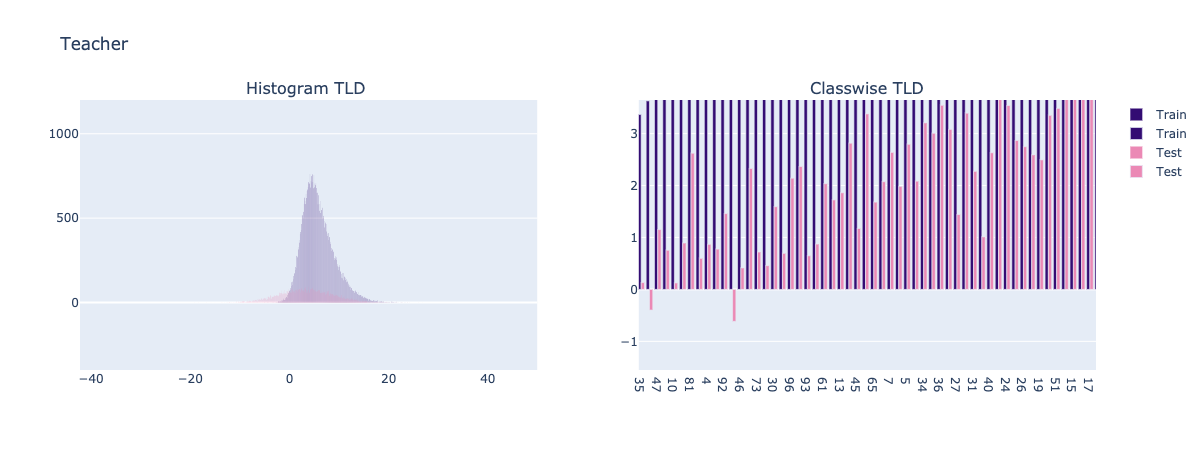

In [7]:
from plotly.subplots import make_subplots

fig =make_subplots(rows=1, cols=2, subplot_titles=("Histogram TLD ", "Classwise TLD"))

df_plot = teacher_df[teacher_df.data_type=='train'].copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig.add_trace(go.Histogram(x=df_plot.tld, name="Train",marker_color='#330C73'), row=1, col=1)

grs = teacher_df[teacher_df.data_type=='train'].groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)

fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld, name="Train",marker_color='#330C73'), row=1, col=2)

df_plot = teacher_df[teacher_df.data_type=='test'].copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig.add_trace(go.Histogram(x=df_plot.tld, name="Test", marker_color='#EB89B5'), row=1, col=1)

grs = teacher_df[teacher_df.data_type=='test'].groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)

fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld, name="Test",  marker_color='#EB89B5',), row=1, col=2)


fig.update_xaxes(type = 'category', row=1,col=2)
fig.update_layout(title="Teacher")

In [ ]:
from plotly.subplots import make_subplots

fig =make_subplots(rows=1, cols=2, subplot_titles=("Histogram TLD ", "Classwise TLD"))

df_plot = student_df[student_df.data_type=='train'].copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig.add_trace(go.Histogram(x=df_plot.tld, name="Train",marker_color='#330C73'), row=1, col=1)

grs = student_df[student_df.data_type=='train'].groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)

fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld, name="Train",marker_color='#330C73'), row=1, col=2)

df_plot = student_df[student_df.data_type=='test'].copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig.add_trace(go.Histogram(x=df_plot.tld, name="Test", marker_color='#EB89B5'), row=1, col=1)

grs = student_df[teacher_df.data_type=='test'].groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)

fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld, name="Test",  marker_color='#EB89B5',), row=1, col=2)


fig.update_xaxes(type = 'category', row=1,col=2)

fig.update_layout(title="Student")

In [ ]:
df_plot = student_df.copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig =make_subplots(rows=1, cols=2, subplot_titles=("TLD Box", "Classwise TLD"))
fig.add_trace(go.Histogram(x=df_plot.tld), row=1, col=1)

grs = student_df.groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)
fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld), row=1, col=2)
fig.update_xaxes(type = 'category', row=1,col=2)

fig.update_layout(title="Student")

In [ ]:
fig =make_subplots(rows=1, cols=2, subplot_titles=("Train", "Test"))


student_df_plot = student_df[(student_df.accuracy==0) & (student_df.data_type=='train')].copy()
teacher_df_plot = teacher_df[(teacher_df.accuracy==0) & (teacher_df.data_type=='train')].copy()

fig.add_trace(go.Histogram(x=student_df_plot.top1_top2,name="Student", opacity=0.5,marker_color='#EB89B5'), row=1, col=1)
fig.add_trace(go.Histogram(x=teacher_df_plot.top1_top2,name="Teacher", opacity=0.5,marker_color='#330C73'), row=1, col=1)

student_df_plot = student_df[(student_df.accuracy==0) & (student_df.data_type=='test')].copy()
teacher_df_plot = teacher_df[(teacher_df.accuracy==0) & (teacher_df.data_type=='test')].copy()

fig.add_trace(go.Histogram(x=student_df_plot.top1_top2,name="Student", opacity=0.5,marker_color='#EB89B5'), row=1, col=2)
fig.add_trace(go.Histogram(x=teacher_df_plot.top1_top2,name="Teacher", opacity=0.5,marker_color='#330C73'), row=1, col=2)
fig.update_layout(title="Teacher vs Student miss classification samples")

* Student가 훨씬 TLD 왼쪽 Tail이 높다

## Sample 별로 비교

In [10]:
student_df.head()

label  top1_top2  top1_gt  accuracy   entropy data_type        tld
0     61   0.836868      0.0         1  0.445626     train   0.836868
1     22  10.017141      0.0         1  0.002374     train  10.017141
2      4   4.495209      0.0         1  0.146341     train   4.495209
3     50   4.458140      0.0         1  0.081993     train   4.458140
4     26   0.072916      0.0         1  2.627294     train   0.072916

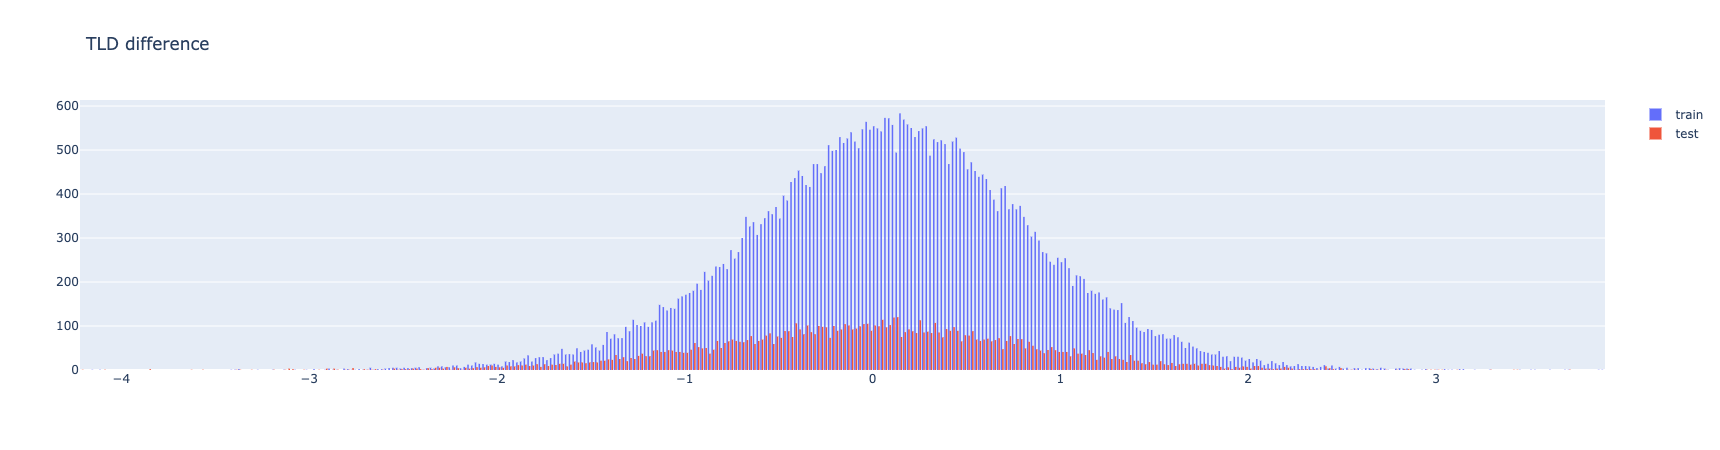

In [88]:
student_df_plot = student_df[(student_df.data_type=='train')].copy()
teacher_df_plot = teacher_df[(teacher_df.data_type=='train')].copy()
sub = teacher_df_plot.tld - student_df_plot.tld
fig = go.Figure()
fig.add_trace(go.Histogram(x=sub, name="train"))

student_df_plot = student_df[(student_df.data_type=='test')].copy()
teacher_df_plot = teacher_df[(teacher_df.data_type=='test')].copy()
sub = teacher_df_plot.tld - student_df_plot.tld
fig.add_trace(go.Histogram(x=sub, name="test"))

fig.update_layout(title="TLD difference")

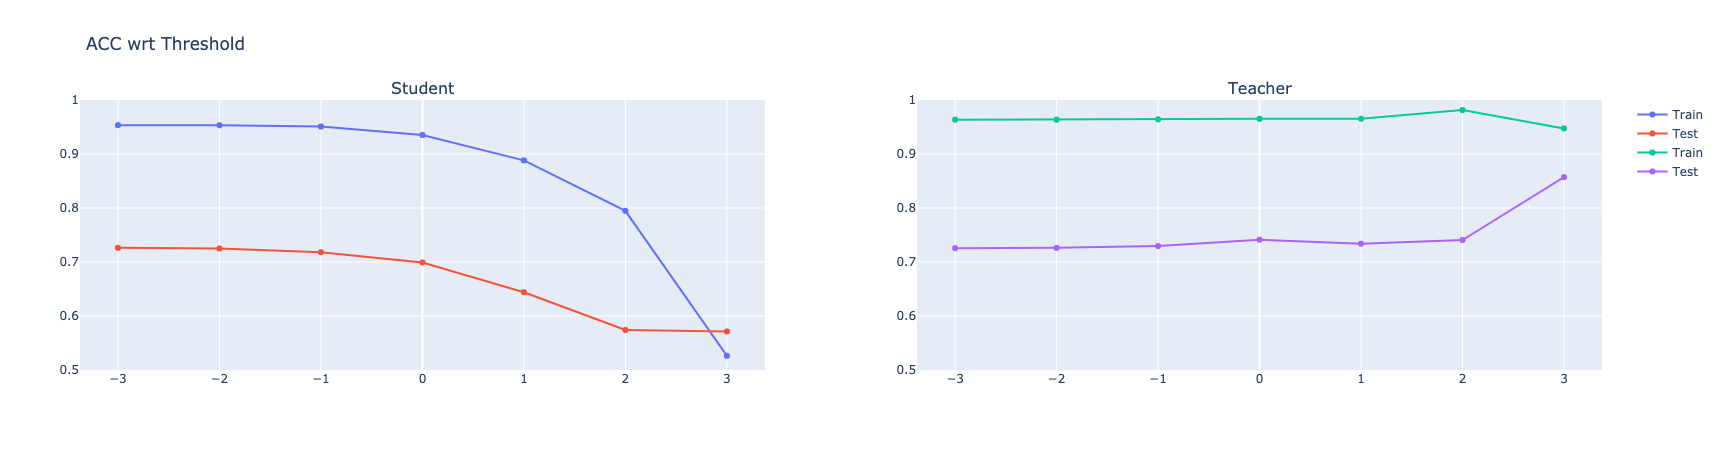

In [131]:
from collections import defaultdict


t_list = [-3, -2 ,-1, 0, 1, 2,3]
accs = defaultdict(list)

fig =make_subplots(rows=1, cols=2, subplot_titles=("Student", "Teacher"))

for dataset_type in ["train", "test"]:
    for threshold in t_list:
        student_df_plot = student_df[(student_df.data_type==dataset_type)].copy()
        teacher_df_plot = teacher_df[(teacher_df.data_type==dataset_type)].copy()
        sub = teacher_df_plot.tld - student_df_plot.tld
        acc = student_df_plot[sub > threshold].accuracy.sum()/(sub>threshold).sum()
        accs[dataset_type].append(acc)

fig.add_trace(go.Scatter(x=t_list, y=accs['train'], name="Train"))
fig.add_trace(go.Scatter(x=t_list, y=accs["test"], name="Test"))

accs = defaultdict(list)
for dataset_type in ["train", "test"]:
    for threshold in t_list:
        student_df_plot = student_df[(student_df.data_type==dataset_type)].copy()
        teacher_df_plot = teacher_df[(teacher_df.data_type==dataset_type)].copy()
        sub = teacher_df_plot.tld - student_df_plot.tld
        acc = teacher_df_plot[sub > threshold].accuracy.sum()/(sub>threshold).sum()
        accs[dataset_type].append(acc)

fig.add_trace(go.Scatter(x=t_list, y=accs['train'], name="Train"), row=1,col=2)
fig.add_trace(go.Scatter(x=t_list, y=accs["test"], name="Test"), row=1,col=2)

fig.update_yaxes(range=(0.5,1))
fig.update_layout(title="ACC wrt Threshold")

### Teacher
* TLD 차이가 클 수록 Test acc가 올라감

### Student
* TLD 차이가 클 수록 Train acc 떨어짐
* TLD 차이가 클 수록 Test acc 도 떨어지는 경향을 보임
* TLD 큰쪽 -> train acc 가 test acc 보다 더 떨어짐 -> 아예 학습이 안된건가? train은 떨어지지만 Test는 그보다 높음

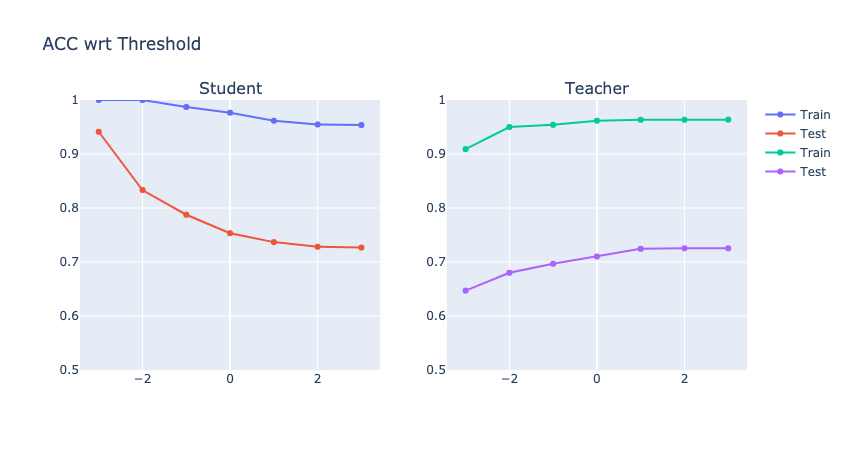

In [132]:
from collections import defaultdict


t_list = [-3, -2 ,-1, 0, 1, 2,3]
accs = defaultdict(list)

fig =make_subplots(rows=1, cols=2, subplot_titles=("Student", "Teacher"))

for dataset_type in ["train", "test"]:
    for threshold in t_list:
        student_df_plot = student_df[(student_df.data_type==dataset_type)].copy()
        teacher_df_plot = teacher_df[(teacher_df.data_type==dataset_type)].copy()
        sub = teacher_df_plot.tld - student_df_plot.tld
        acc = student_df_plot[sub < threshold].accuracy.sum()/(sub < threshold).sum()
        accs[dataset_type].append(acc)

fig.add_trace(go.Scatter(x=t_list, y=accs['train'], name="Train"))
fig.add_trace(go.Scatter(x=t_list, y=accs["test"], name="Test"))

accs = defaultdict(list)
for dataset_type in ["train", "test"]:
    for threshold in t_list:
        student_df_plot = student_df[(student_df.data_type==dataset_type)].copy()
        teacher_df_plot = teacher_df[(teacher_df.data_type==dataset_type)].copy()
        sub = teacher_df_plot.tld - student_df_plot.tld
        acc = teacher_df_plot[sub < threshold].accuracy.sum()/(sub < threshold).sum()
        accs[dataset_type].append(acc)

fig.add_trace(go.Scatter(x=t_list, y=accs['train'], name="Train"), row=1,col=2)
fig.add_trace(go.Scatter(x=t_list, y=accs["test"], name="Test"), row=1,col=2)

fig.update_yaxes(range=(0.5,1))
fig.update_layout(title="ACC wrt Threshold")

### Student
* teacher.tld - student.tld 차이가 음수쪽으로 큰 것 -> student.tld가 확신이 크고 teacher는 작음
* Student TLD 가 클 때 train, test acc 모두 크다? student TLD가 teacher 따라가도록 하는데 student가 어떻게 커진 것일까
* 이 부분 때문에 test acc가 좋게 나온다고 판단됨
* Teacher 입장에서 TLD가 낮다 (Teacher가 틀렸다)
* Student는 높게 나옴. Student train_acc =0 -> 해당 train sample에 대해 다 맞췄다

In [159]:
tmp = student_df_plot[student_df_plot.tld > student_df_plot.tld.quantile(0.2)]
tmp.accuracy.sum()/len(tmp)

0.90825

In [162]:
 teacher_df_plot.head()

label  top1_top2   top1_gt  accuracy   entropy data_type epoch  data_index  \
0     49   2.663302  5.131505         0  1.276246      test   199           0   
1     33   3.160002  0.000000         1  0.421849      test   199           1   
2     72   0.054648  0.000000         1  1.342354      test   199           2   
3     51   3.622550  0.000000         1  0.368620      test   199           3   
4     71   0.495723  0.000000         1  0.770180      test   199           4   

        tld  
0 -5.131505  
1  3.160002  
2  0.054648  
3  3.622550  
4  0.495723

In [163]:
student_df_plot.head()

label  top1_top2   top1_gt  accuracy   entropy data_type epoch  data_index  \
0     49   2.298163  5.598157         0  1.276246      test   199           0   
1     33   3.070262  0.000000         1  0.421849      test   199           1   
2     72   0.751636  0.000000         1  1.342354      test   199           2   
3     51   4.331349  0.000000         1  0.368620      test   199           3   
4     71   2.062700  0.000000         1  0.770180      test   199           4   

        tld  
0 -5.598157  
1  3.070262  
2  0.751636  
3  4.331349  
4  2.062700